In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import glob
import cv2
import torch
import torch.nn as nn

# from torchstat import stat
import glob
import torch.optim as optim


import os
print(os.listdir("../input/train/"))

# Any results you write to the current directory are saved as output.

['masks', 'images']


In [2]:

import torch
import torch.nn as nn

class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(input_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()
        
#         self.up1=torch.nn.ConvTranspose2d(12,25,3,stride=2,padding=1)

    def forward(self, prev_feature_map, x,k):
#         print('before up',x.size())
        if k!=0:
            x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        
        self.mid_conv1 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.mid_conv2 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.mid_conv3 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(64)

        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)
        self.up_block7 = UNet_up_block(3, 16, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 3, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(3)
        self.last_conv2 = torch.nn.Conv2d(3, 2, 1, padding=0)
        self.relu = torch.nn.ReLU()
        
        self.max_pool = torch.nn.MaxPool2d(2, 2)

    def forward(self, x):
#         ins=x.clone()
        self.x1 = self.down_block1(x)
#         print('self.x1',self.x1.size())
        self.x2 = self.down_block2(self.x1)
#         print('self.x2',self.x2.size())
        self.x3 = self.down_block3(self.x2)
#         print('self.x3',self.x3.size())
         
#         self.mid=self.max_pool(self.x3)    
 

        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x3)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        
#         print('prev,x',self.x7.size(),self.x3.size())
        
        x = self.up_block5(self.x3, self.x7,k=0)
#         print('self.x',x.size())
        x = self.up_block6(self.x2, x,k=1)
#         print('6',x.size())
        
        x=self.up_block7(self.x1,x,k=1)
#         print('7',x.size())
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
#         print(' out',x.size())
        return x
def standard(x):
    mean=np.mean(x)
    
    return((x-mean)/np.std(x))


class DatasetSalt(Dataset):
    
    def __init__(self, file_path='../input/train/images/*', transform=None,limit_paths=len(glob.glob('../input/train/images/*'))):
        self.path = glob.glob(file_path)
        
        self.path=self.path[:limit_paths]
        self.transform = transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        
        images = cv2.imread(self.path[index])
        images=images[:-1,:-1,:]
        
        images=standard(images)
        
        images=torch.from_numpy(images)
        images.transpose_(1,2)
        images.transpose_(0,1)
        
        
        
        mks='../input/train/masks/'+self.path[index][len('../input/train/images/'):]
        
        labels=cv2.imread(mks)[:-1,:-1,0]
        
        labels=labels/255
        

        
        sample={'image': images,'label': torch.from_numpy(labels)}
        
        if self.transform is not None:
            image = self.transform(image)
            
        return sample


# def dice(input, target,weights=torch.tensor([0.9,0.1]).cuda()):
#     smooth=.001
#     input=input.view(-1)
#     target=target.view(-1)
    
#     #create opp labels
#     target2=1-target
#     input2=1-input
    
#     score1=2*(input*target).sum()/(input.sum()+target.sum()+smooth) #1s orig
#     score2=2*(input2*target2).sum()/(input2.sum()+target2.sum()+smooth) #0's orig
    
    
#     score=1-(weights[0]*score1+weights[1]*score2)/2
#     if score<0:
#         score=score-score
    
#     return(score)
  


In [7]:

def dice(input, target,weights=torch.tensor([1,1]).float().cuda()):
    smooth=.001
    
    dummy=np.zeros([batch_size,2,100,100]) # create dummy to one hot encode target for weighted dice
    dummy[:,0,:,:][target==0]=1 # background class is 0
    dummy[:,1,:,:][target==1]=1 # salt class is 1 
    
    
    target=torch.tensor(dummy).float().cuda()
    
#     print(input.size(),input[:,0,:,:].size())
    input1=input[:,0,:,:].contiguous().view(-1) #flatten both classes seperately
    target1=target[:,0,:,:].contiguous().view(-1)
    
    input2=input[:,1,:,:].contiguous().view(-1)
    target2=target[:,1,:,:].contiguous().view(-1)
    
    score1=2*(input1*target1).sum()/(input1.sum()+target1.sum()+smooth) #back
    score2=2*(input2*target2).sum()/(input2.sum()+target2.sum()+smooth) #salt

    
    score=1-(weights[0]*score1+weights[1]*score2)/2
    if score<0:
        score=score-score
    
    return(score)
  

In [8]:
soft_max=torch.nn.Softmax(dim=1)

def train(epoch):
    for idx, batch_data in enumerate(dataloader) : 
        x, target=batch_data['image'].float().cuda(),batch_data['label'].float().cuda()


        optimizer.zero_grad()
        output = net(x)
#         print(output.size())
        output.squeeze_(1)

#         print('out',output.size(),target.size())
        bce_loss = criterion(output, target.long())
        lc.append(bce_loss.item())

        dice_loss = dice((output), target)
        ld.append(dice_loss.item())
        loss =  dice_loss + bce_loss
        l.append(loss.item())

        loss.backward()
        optimizer.step()

        print('Epoch {}, loss {}, bce {}, dice {}'.format(
            epoch, sum(l)/len(l), sum(lc)/len(lc) , sum(ld)/len(ld) ))




In [11]:
      
batch_size=10
 
net = UNet().cuda()

optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3,0.7]).cuda())


dataset=DatasetSalt(limit_paths=10)
dataloader=DataLoader(dataset,batch_size, shuffle=True, num_workers=2)


In [14]:

ld=[]
lc=[]
l=[]
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)


for epoch in range(1000):train(epoch)

Epoch 0, loss 1.6740732735141794, bce 0.5723414310702571, dice 1.101587417911976
Epoch 1, loss 1.673726949426863, bce 0.5722778841068871, dice 1.10130574148168
Epoch 2, loss 1.6741589455228103, bce 0.5721294614657058, dice 1.1018876960403041
Epoch 3, loss 1.6718351188754537, bce 0.5719691052411994, dice 1.09972580721241
Epoch 4, loss 1.6697585020835202, bce 0.5718008137737531, dice 1.0978190889582038
Epoch 5, loss 1.6689814344588956, bce 0.5716339908924299, dice 1.0972104270223508
Epoch 6, loss 1.6680556520358802, bce 0.57146424024533, dice 1.0964559768278574
Epoch 7, loss 1.6668659855157901, bce 0.5712926083681534, dice 1.0954395168866866
Epoch 8, loss 1.6669372657732087, bce 0.5711305861545698, dice 1.095674328962151
Epoch 9, loss 1.666284695192037, bce 0.5709703838584399, dice 1.0951834460200391
Epoch 10, loss 1.6652938184714077, bce 0.5708102712679148, dice 1.094354151475309
Epoch 11, loss 1.66402554541976, bce 0.5706528002023696, dice 1.0932447910308838
Epoch 12, loss 1.6632032707

Epoch 100, loss 1.5334535110741854, bce 0.5499599117102507, dice 0.9834770355373621
Epoch 101, loss 1.5322406174402337, bce 0.5496760324157518, dice 0.9825490607934839
Epoch 102, loss 1.530980877013042, bce 0.5493973187359747, dice 0.9815690488650881
Epoch 103, loss 1.5293453053100823, bce 0.5491177790785489, dice 0.9802140271950424
Epoch 104, loss 1.5279491917319494, bce 0.5488276532485623, dice 0.9791090792580827
Epoch 105, loss 1.5266972615450316, bce 0.5485295209349418, dice 0.9781563414241674
Epoch 106, loss 1.524859142749488, bce 0.5482127984701577, dice 0.9766360610520759
Epoch 107, loss 1.522915550005638, bce 0.5478711658837022, dice 0.9750352938296432
Epoch 108, loss 1.5216360599608034, bce 0.5475322249963227, dice 0.9740959206545675
Epoch 109, loss 1.520410464267538, bce 0.5471967921761058, dice 0.9732069138324622
Epoch 110, loss 1.5192385587916277, bce 0.5468506728326995, dice 0.9723823116529708
Epoch 111, loss 1.5178153203881306, bce 0.5465058178702991, dice 0.9713051002161

Epoch 199, loss 1.4068148100714968, bce 0.5055926872282913, dice 0.9013244408045629
Epoch 200, loss 1.405753325248502, bce 0.5049972184825986, dice 0.900859695734437
Epoch 201, loss 1.4043408411634, bce 0.5044018239547045, dice 0.9000438704588726
Epoch 202, loss 1.4029883580330091, bce 0.5038108706016979, dice 0.8992835871684246
Epoch 203, loss 1.4016699123260614, bce 0.5032243635125306, dice 0.8985528772139488
Epoch 204, loss 1.40029654408596, bce 0.5026377429640627, dice 0.8977673522063664
Epoch 205, loss 1.39891745919793, bce 0.5020526503850966, dice 0.896974572395247
Epoch 206, loss 1.3978571772272816, bce 0.5014724974390826, dice 0.896495637252246
Epoch 207, loss 1.3968007922172547, bce 0.5008957301727449, dice 0.8960171987738791
Epoch 208, loss 1.395713636519933, bce 0.5003172780014106, dice 0.8955096728873976
Epoch 209, loss 1.3946850802796313, bce 0.49973407956823035, dice 0.895065498592271
Epoch 210, loss 1.393620306523002, bce 0.4991450402372164, dice 0.8945909564818569
Epoch

Epoch 297, loss 1.2921059457297177, bce 0.44204154558510445, dice 0.8502770763082602
Epoch 298, loss 1.2911631764207847, bce 0.4413695720921307, dice 0.8500072255791951
Epoch 299, loss 1.290196513982769, bce 0.4406984839283052, dice 0.8497125906621161
Epoch 300, loss 1.2892294498007806, bce 0.4400280762334299, dice 0.849416868242084
Epoch 301, loss 1.288170037703524, bce 0.43935872184074654, dice 0.8490277386150478
Epoch 302, loss 1.2871075745748013, bce 0.4386900115583676, dice 0.8486349087588642
Epoch 303, loss 1.2860485923508762, bce 0.43802234849975846, dice 0.8482445066912354
Epoch 304, loss 1.2848274798654928, bce 0.4373572326849005, dice 0.8476894182887503
Epoch 305, loss 1.2836299071930968, bce 0.43669223542577823, dice 0.8471577472183816
Epoch 306, loss 1.2824310057076365, bce 0.43602586093575063, dice 0.8466261236773811
Epoch 307, loss 1.2812115598206568, bce 0.4353608033289352, dice 0.8460726324958031
Epoch 308, loss 1.2801583542698813, bce 0.43469762785633803, dice 0.845683

Process Process-1287:
Process Process-1288:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(

KeyboardInterrupt: 

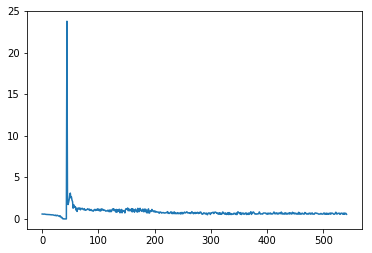

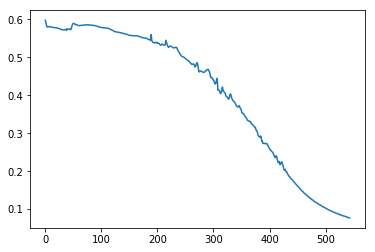

In [15]:
plt.plot(ld)
plt.show()

plt.plot(lc)
plt.show()

In [ ]:
def train(epoch):
    for idx, batch_data in enumerate(dataloader):
        x, target=batch_data['image'].float().cuda(),batch_data['label'].float().cuda()


        optimizer.zero_grad()
        output = net(x)
        output.squeeze_(1)
#         print(target.size())
        ran=np.random.randint(0,10,1)[0]
        
        temp=torch.sigmoid(output[ran]).cpu().detach().numpy()
        temp[temp>0.5]=1
        temp[temp<0.5]=0
#         print(temp)
        
        print('pred')

        
        plt.imshow(temp[1])
        plt.show()
        
        plt.imshow(target[ran].cpu().detach().numpy())
        plt.show()
#         print(target[ran].cpu().detach().numpy())

        bce_loss = criterion(output, target.long())


#         dice_loss = dice(output, target)
#         loss = bce_loss #+ dice_loss 
#         loss.backward()
#         optimizer.step()
        
        
        
#         print('Epoch {}, loss {}, bce {}, dice {}'.format(
#             idx, loss.item(), bce_loss.item(), dice_loss.item()))




In [ ]:
for epoch in range(10):train(epoch)

In [ ]:
#with bce+dice
for i in range(1000):train()

In [ ]:
def twod_one_hot(targets):    # one hot encodes 3D block to 5 channels with each channel as only one class
    targets_extend=targets.clone().long() # long needed
    targets_extend.unsqueeze_(1) # convert to Nx1xHxW
    one_hot = torch.FloatTensor(targets_extend.size(0), 1, targets_extend.size(2)).zero_() # add zero axis
    print(one_hot.size(),one_hot)
    one_hot.scatter_(1,targets_extend ,one_hot) # scatter
    return one_hot

In [ ]:
twod_one_hot(torch.tensor(tar))

In [ ]:
target=plt.imread("../input/train/images/aabb4516d1.png")

In [ ]:
np.shape(tar)
target=np.expand_dims(target,0)

In [ ]:
smooth=.001
    
dummy=np.zeros([batch_size,2,101,101]) # create dummy to one hot encode target
dummy[:,0,:,:][target[==0]=1 # background class is 0
dummy[:,1,:,:][target==1]=1 # salt class is 1 

plt.imshow(dummy[0,0,:,:])
plt.show()

plt.imshow(dummy[0,1,:,:])
plt.show()

In [ ]:
np.shape(dummy)